<a href="https://colab.research.google.com/github/brettmorrisonAO5ANNEX/CSPAD/blob/main/updated_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyWavelets

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pywt
import statsmodels.api as sm
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, savgol_filter, butter, filtfilt
from scipy.ndimage import gaussian_filter1d

# Fetch Data

In [81]:
def process_csv(file_path):
    try:
        # Read the CSV, skipping the first 6 rows (0-based index) to start from the headers
        df = pd.read_csv(file_path, skiprows=6)

        # Strip any leading/trailing spaces from column names
        df.columns = df.columns.str.strip()

        # Ensure the first column is "Seconds" and extract it
        if df.columns[0].lower() != 'seconds':
            raise ValueError("Expected first column to be 'Seconds'.")

        seconds = df.iloc[:, 0]  # First column (Seconds)

        # Identify voltage and current columns while skipping the last temperature column
        voltage_columns = [col for col in df.columns if 'Voltage' in col and 'Temp' not in col]
        current_columns = [col for col in df.columns if 'Current' in col and 'Temp' not in col]

        # Create a dictionary to store the extracted data
        serial_data = {'Seconds': seconds.tolist()}

        for v_col, c_col in zip(voltage_columns, current_columns):
            serial_number = v_col.replace('Voltage', '').strip()  # Extract serial number
            serial_data[serial_number] = {
                'Voltage': df[v_col].tolist(),
                'Current': df[c_col].tolist()
            }

        return serial_data

    except Exception as e:
        print(f"Error processing CSV: {e}")
        return None

# New Segmentation Algo

## Overview
A new method for segmenting power cycle data from a timeseries dataset.
####Steps
1. Smoothing
2. Neutralize Outliers (NEW)
3. Gradient-based Binary Threshold Segmentation

### Helpers

In [87]:
def detect_cycles(time, current, threshold=0.05):
    """
    Detect cycles by identifying rising edges in the current signal.

    Args:
        time (list): List of time values.
        current (list): List of current values.
        threshold (float): Threshold for detecting "on" state.

    Returns:
        list of tuples: Each tuple contains (time_segment, current_segment).
    """
    cycles = []
    start_idx = None

    for i in range(1, len(current)):
        if current[i] > threshold and current[i - 1] <= threshold:
            start_idx = i
        elif current[i] <= threshold and current[i - 1] > threshold and start_idx is not None:
            cycles.append((time[start_idx:i], current[start_idx:i]))
            start_idx = None

    return cycles

In [88]:
def extract_cycles(seconds, data):
  current = data['Current']
  cycles = detect_cycles(seconds, current)
  return cycles

### Main Functions

#### Step 1: Smoothing
There are many different options for smoothing: compare and contrast each
1. Moving Average
2. Savitzky-Golay Filter
3. Gaussian Smoothing
4. Exponential Smoothing
5. Low-pass Filtering
6. Fourier Transform Smoothing
7. Wavelet Transform Smoothing
8. LOESS


In [89]:
def moving_average_smoothing(current, window_size=5):
    smoothed_current = pd.Series(current).rolling(window=window_size, center=True, min_periods=1).mean()
    return np.array(smoothed_current)

In [90]:
def savgol_smoothing(current, window_size=11, poly_order=2):
    smoothed_current = savgol_filter(current, window_size, poly_order)
    return np.array(smoothed_current)

In [91]:
def gaussian_smoothing(current, sigma=2):
    smoothed_current = gaussian_filter1d(current, sigma=sigma)
    return np.array(smoothed_current)

In [92]:
def exponential_smoothing(current, alpha=0.2):
    smoothed_current = np.zeros_like(current)
    smoothed_current[0] = current[0]
    for i in range(1, len(current)):
        smoothed_current[i] = alpha * current[i] + (1 - alpha) * smoothed_current[i - 1]

    return np.array(smoothed_current)

In [93]:
def low_pass_filter(time, current, cutoff=0.1, order=4):
    # Compute sampling frequency
    dt = np.mean(np.diff(time))  # Average time step
    nyquist_freq = 0.5 / dt  # Nyquist frequency
    normalized_cutoff = cutoff / nyquist_freq  # Normalize cutoff frequency

    # Design low-pass Butterworth filter
    b, a = butter(order, normalized_cutoff, btype='low', analog=False)

    # Apply filter using filtfilt (zero-phase filtering)
    smoothed_current = filtfilt(b, a, current)

    return np.array(smoothed_current)

In [94]:
def fft_smoothing(time, current, cutoff_fraction=0.1):
    n = len(current)  # Number of samples
    freq = np.fft.fftfreq(n, d=np.mean(np.diff(time)))  # Frequency components
    fft_values = np.fft.fft(current)  # Compute FFT

    # Create a low-pass filter: Zero out high-frequency components
    cutoff_idx = int(cutoff_fraction * n)  # Determine cutoff index
    fft_values[cutoff_idx:-cutoff_idx] = 0  # Remove high frequencies (keep low frequencies)

    # Inverse FFT to get smoothed signal
    smoothed_current = np.fft.ifft(fft_values).real

    return np.array(smoothed_current)

In [95]:
def wavelet_transform_smoothing(current, wavelet='db4', level=2, threshold_factor=0.2):
    # Perform wavelet decomposition (breaking down the signal into approximations and details)
    coeffs = pywt.wavedec(current, wavelet, level=level)

    # Apply thresholding to the detail coefficients to remove noise
    coeffs_thresholded = [pywt.threshold(c, threshold_factor * np.max(c)) for c in coeffs]

    # Reconstruct the signal using the thresholded coefficients
    smoothed_data = pywt.waverec(coeffs_thresholded, wavelet)

    # Ensure the smoothed data has the same length as the original data
    smoothed_data = smoothed_data[:len(current)]

    return np.array(smoothed_data)

In [96]:
def loess_smoothing(time, current, frac=0.2):
    # Fit a LOESS model to the data
    lowess = sm.nonparametric.lowess(current, time, frac=frac)

    # The smoothed data is the second column of the result
    smoothed_data = lowess[:, 1]

    return np.array(smoothed_data)

In [97]:
def step_one(time, current, method_id=1):
  smoothing_dict = {
      1: moving_average_smoothing(current),
      2: savgol_smoothing(current),
      3: gaussian_smoothing(current),
      4: exponential_smoothing(current),
      5: low_pass_filter(time, current),
      6: fft_smoothing(time, current),
      7: wavelet_transform_smoothing(current),
      8: loess_smoothing(time, current)
  }

  return smoothing_dict.get(method_id)

#### Step 2: Neutralize Outliers

In [98]:
# Step 2: Neutralize Outliers

#### Step 3: Gradient-Based Binary Threshold Segmentation

In [99]:
# Step 3: Gradient-Based Threshold Segmentation

### Full Algorithm

In [106]:
def new_segmentation_algo(df):
  # extract all cycles for the current SN
  for serial, data in df.items():
    if serial == "Seconds":
      continue
    cycles = extract_cycles(df['Seconds'], data)

    for i, (time_segment, current_segment) in enumerate(cycles):
      # Step 1
      """
      OPTIONS (method_id):
      1. Moving Average (default)
      2. Savitzky-Golay Filter
      3. Gaussian Smoothing
      4. Exponential Smoothing
      5. Low-pass Filtering
      6. Fourier Transform Smoothing
      7. Wavelet Transform Smoothing
      8. LOESS
      """
      #TESTING
      plot_smoothing_methods(time_segment, current_segment)
      break
    break
      # Step 1
      #smoothed_current = step_one(time_segment, current_segment, 1)
      # Step 2

      # Step 3

# Experimental

In [114]:
def plot_smoothing_methods(time, current):
    """
    Plot the time vs smoothed current for different smoothing methods.

    Parameters:
    - time: Array of time data.
    - current: Array of current data to be smoothed.
    """
    # Smoothing dictionary
    smoothing_dict = {
        1: (moving_average_smoothing(current), "Moving Average"),
        2: (savgol_smoothing(current), "Savitzky-Golay Filter"),
        3: (gaussian_smoothing(current), "Gaussian Smoothing"),
        4: (exponential_smoothing(current), "Exponential Smoothing"),
        5: (low_pass_filter(time, current), "Low-pass Filtering"),
        6: (fft_smoothing(time, current), "Fourier Transform Smoothing"),
        7: (wavelet_transform_smoothing(current), "Wavelet Transform Smoothing"),
        8: (loess_smoothing(time, current), "LOESS Smoothing")
    }

    # Create a figure with 4x2 subplots
    fig, axs = plt.subplots(4, 2, figsize=(12, 10))

    # Flatten the 2D array of subplots for easy iteration
    axs = axs.flatten()

    # Loop through each method and plot
    for method_id, ax in zip(smoothing_dict.keys(), axs):
        smoothed_current = smoothing_dict[method_id][0]

        # Plot the raw data as scatter points
        ax.scatter(time, current, color='red', alpha=0.5, label='Raw Data', s=10)

        # Plot the smoothed data as a line
        ax.plot(time, smoothed_current, label=f'{smoothing_dict[method_id][1]}', linewidth=2)

        # Set the title, labels, and legend
        ax.set_title(smoothing_dict[method_id][1])
        ax.set_xlabel('Time')
        ax.set_ylabel('Smoothed Current')
        ax.legend()

    # Adjust layout to prevent overlapping titles
    plt.tight_layout()
    plt.show()

In [102]:
def process_and_plot_cycles(serial_data, smoothing_window=11, poly_order=2):
  seconds = serial_data['Seconds']

  for serial, data in serial_data.items():
      if serial == "Seconds":
          continue

      current = data['Current']
      cycles = detect_cycles(seconds, current)

      for i, (time_segment, current_segment) in enumerate(cycles):
          time_segment = np.array(time_segment) - time_segment[0]  # Normalize time

          # Apply smoothing to the current data before computing the gradient
          smoothed_current = savgol_filter(current_segment, smoothing_window, poly_order)

          # Compute gradient on the smoothed data
          gradient = np.gradient(smoothed_current, time_segment)
          abs_gradient = np.abs(gradient)

          # Smooth the absolute gradient
          smoothed_gradient = savgol_filter(abs_gradient, smoothing_window, poly_order)

          # Find peaks in the smoothed gradient
          peaks, _ = find_peaks(smoothed_gradient)
          peak_values = smoothed_gradient[peaks]

          # Determine the 3rd largest peak (binary threshold)
          if len(peak_values) >= 3:
              threshold_value = np.sort(peak_values)[-3]  # 3rd largest peak
          else:
              threshold_value = np.max(peak_values) if len(peak_values) > 0 else 0  # Default to max if < 3 peaks

          # Create a binary thresholded gradient
          binary_thresholded_gradient = np.where(smoothed_gradient > threshold_value, 1, 0)

          # Find the changepoints in the binary thresholded data (transition from 0 -> 1 or 1 -> 0)
          changepoints = np.where(np.diff(binary_thresholded_gradient) != 0)[0] + 1  # +1 to adjust for diff shift

          # Plot raw data (left), smoothed gradient (middle), and binary thresholded gradient (right)
          fig, axs = plt.subplots(1, 3, figsize=(15, 5))

          # Left plot: Smoothed Data with changepoints as vertical lines
          axs[0].plot(time_segment, smoothed_current, label="Smoothed Current", color='b')
          for changepoint in changepoints:
              axs[0].axvline(x=time_segment[changepoint], color='g', linestyle='--', label="Changepoint" if changepoint == changepoints[0] else "")
          axs[0].set_xlabel("Time (seconds, normalized)")
          axs[0].set_ylabel("Current")
          axs[0].set_title(f"Smoothed Data - {serial} (Cycle {i+1})")
          axs[0].grid(True)
          axs[0].legend()

          # Middle plot: Smoothed Gradient
          axs[1].plot(time_segment, smoothed_gradient, label="Smoothed |Gradient|", color='r')
          axs[1].axhline(y=threshold_value, color='k', linestyle='--', label="Binary Threshold")
          axs[1].set_xlabel("Time (seconds, normalized)")
          axs[1].set_ylabel("Gradient Magnitude")
          axs[1].set_title(f"Smoothed Absolute Gradient - {serial} (Cycle {i+1})")
          axs[1].grid(True)
          axs[1].legend()

          # Right plot: Binary Thresholded Gradient
          axs[2].plot(time_segment, binary_thresholded_gradient, label="Binary Thresholded Gradient", color='g')
          axs[2].set_xlabel("Time (seconds, normalized)")
          axs[2].set_ylabel("Binary Gradient")
          axs[2].set_title(f"Binary Thresholded Gradient - {serial} (Cycle {i+1})")
          axs[2].grid(True)

          plt.tight_layout()
          plt.show()

In [103]:
#df = process_csv('data.csv')
#process_and_plot_cycles(df)

# Testing Environment

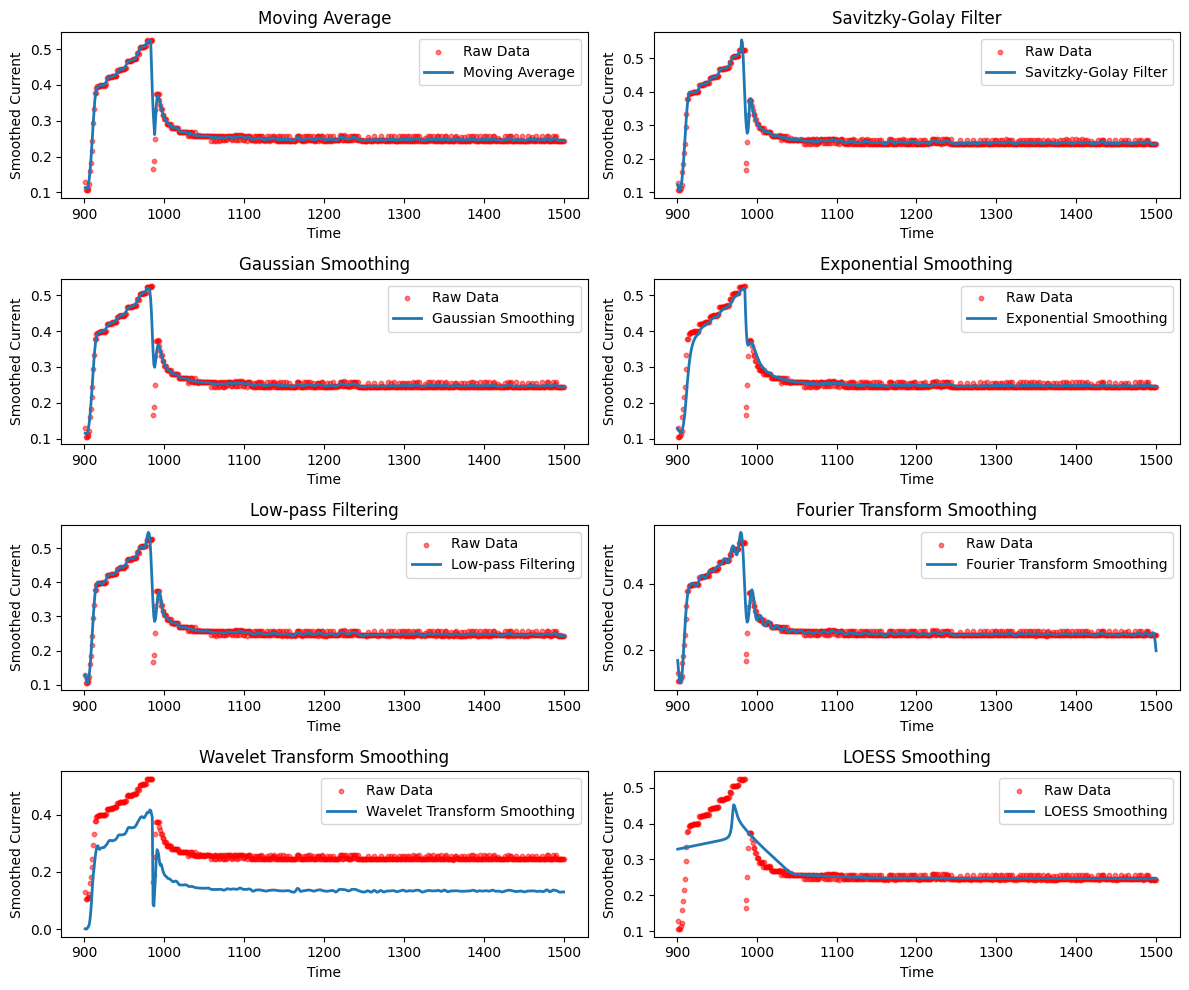

In [115]:
df = process_csv('data.csv')
new_segmentation_algo(df)